In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
inflation = pd.read_csv('Price_index.csv',index_col = 0)

inflation.columns = ['price']
inflation['delta'] = ((inflation['price'] - inflation['price'].shift(12))/inflation['price']) * 100
inflation = inflation.loc['1976-01-01':'2017-03-01']
#print(inflation)

difference = pd.read_csv('M2_less_small_time_deposits.csv', index_col = 0)
difference.columns = ['M2_less_deposits']
difference['M2_less_deposits'] = difference['M2_less_deposits'] / 1000

delta_difference = ((difference['M2_less_deposits'] - difference['M2_less_deposits'].shift(12))/difference['M2_less_deposits']) * 100

delta_difference = pd.DataFrame(delta_difference)
delta_difference = delta_difference.loc['1976-01-01':'2017-03-01']


## Je m'assure du type de données ##
inflation.astype(dtype = 'float')
delta_difference.astype(dtype = 'float')

delta_difference.columns=['M2_less_deposits']

<Figure size 432x288 with 0 Axes>

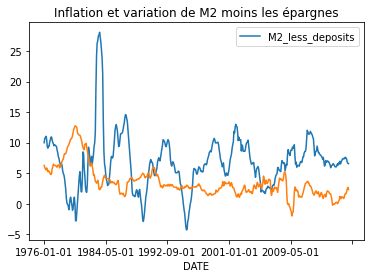

In [6]:
plt.figure()
delta_difference.plot()
inflation['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

In [7]:
############# Analyse statistique de base #############

## inlfation et delta différence entre 1976 et 2017 ##

x1 = inflation['delta'].values
y1 = delta_difference['M2_less_deposits'].values

from scipy.stats import pearsonr
coeff_pearson = pearsonr(x1,y1)
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = (-0.3209040420970541, 2.5549527247277276e-13)


<Figure size 432x288 with 0 Axes>

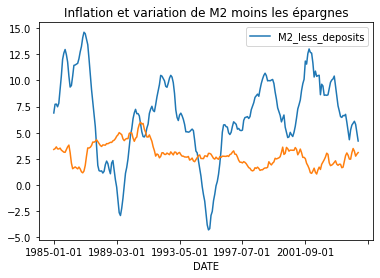

In [10]:
## inlfation et delta différence entre 1985 et 2005 ##

delta_difference_1985 = delta_difference.loc['1985-01-01':'2005-03-01']
inflation_1985 = inflation.loc['1985-01-01':'2005-03-01']

plt.figure()
delta_difference_1985.plot()
inflation_1985['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

In [12]:
############# Analyse statistique de base #############

x2 = inflation_1985['delta'].values
y2 = delta_difference_1985['M2_less_deposits'].values

from scipy.stats import pearsonr
coeff_pearson = pearsonr(x2,y2)
print("coefficient de Pearson après 1985 = {}".format(coeff_pearson))

coefficient de Pearson après 1985 = (-0.44709365183487226, 2.413011954227127e-13)
